In [29]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import least_squares

In [2]:
def average_rows(x,nblock=100):
    nr=x.shape[0]//nblock
    nc=x.shape[1]
    y=np.zeros((nr,nc),dtype=x.dtype)
    for i in range(nr):
        y[i,:]=np.mean(x[i*nblock:(i+1)*nblock],axis=0)
    return y

In [ ]:
def get_coarse_xcorr(f1,f2,chans=None):
    """ Get coarse xcorr of each channel of two channelized timestreams.
    The xcorr is 0-padded, so length of output is twice the original length (shape[0]).
    
    Parameters
    ----------
    f1, f2 : ndarray of complex64
        First and second timestreams. Both n_spectrum x n_channel complex array.
    chans: tuple of int
        Channels (columns) of f1 and f2 that should be correlated.
    
    Returns
    -------
    ndarray of complex128
        xcorr of each channel's timestream. 2*n_spectrum x n_channel complex array.
    """
    Nsmall=f1.shape[0]
    print("Shape of passed channelized timestream =", f1.shape)
    if chans is None:
        chans = np.arange(f1.shape[1])
    xcorr=np.zeros((len(chans),2*Nsmall),dtype='complex128')
    win=np.hamming(2*Nsmall)
    wt = np.zeros(2*Nsmall)
    wt[:Nsmall] = 1
    n_avg = np.fft.irfft(np.fft.rfft(wt)*np.conj(np.fft.rfft(wt)))
    print(n_avg)
    for i,chan in enumerate(chans):
        print("processing chan", chan)
        xcorr[i, :] = np.fft.ifft(
                        np.fft.fft(np.hstack([f1[:, chan].flatten(), np.zeros(Nsmall, dtype="complex128")]))
                        * np.conj(
                            np.fft.fft(np.hstack([f2[:, chan].flatten(), np.zeros(Nsmall, dtype="complex128")]))
                        )
                    )
        xcorr[i, :]=xcorr[i, :]/n_avg
    print(xcorr.shape)
    return np.ma.masked_invalid(xcorr)

@nb.njit(parallel=True,cache=True)
def make_complex(cmpl,mag,phase):
    N=cmpl.shape[0]
    for i in nb.prange(0,N):
        cmpl[i] = mag[i]*np.exp(1J*phase[i])

def get_interp_xcorr(coarse_xcorr, freq, sample_no, coarse_sample_no, offset, osamp=1):
    print("coarse shape", coarse_xcorr.shape)
    t1=time.time()
    final_xcorr_cwave = np.empty((coarse_xcorr.shape[0]-1)*8192*osamp,dtype='complex128')
    print("Total upsampled timestream samples in this coarse chunk =",sample_no.shape)
    t2=time.time()
    print("generation",t2-t1)
    sample_no2 = sample_no + offset
    t1=time.time()
    uph=np.unwrap(np.angle(coarse_xcorr))
    t2=time.time()
    print("unwrap",t2-t1)
    newphase=2*np.pi*freq*np.arange(0,coarse_xcorr.shape[0])+uph
    t1=time.time()
    newphase=np.interp(sample_no,coarse_sample_no,newphase)
    t2=time.time()
    print("interp", t2-t1)
    t1=time.time()
    cs=CubicSpline(coarse_sample_no,np.abs(coarse_xcorr))
    t2=time.time()
    print("CS gen", t2-t1)
    t1=time.time()
    newmag=cs(sample_no2)
    t2=time.time()
    print("cs eval",t2-t1)
    t1=time.time()
    
    t1=time.time()
    make_complex(final_xcorr_cwave,newmag,newphase)
    t2=time.time()
    print("make complex",t2-t1)
    # newmag = np.interp(x,np.arange(0,len(y))*4096,np.abs(c1full))
    return final_xcorr_cwave

In [8]:
with np.load("../spectra_1830_1840_4096_drift_delay.npz") as f:
    spec1=f['spectra1']
    spec2=f['spectra2']
    delays=f['delays']

In [ ]:
cxcorr = get_coarse_xcorr(spec1[:10000,4:6], spec2[:10000,4:6])

Shape of passed channelized timestream = (10000, 2)
[10000.  9999.  9998. ...  9997.  9998.  9999.]
processing chan 0
processing chan 1
(2, 20000)


/tmp/ipykernel_1049567/393562261.py:35: RuntimeWarning: divide by zero encountered in divide
  xcorr[i, :]=xcorr[i, :]/n_avg


In [14]:
N=cxcorr.shape[1]
# N=newxcorr.shape[1]
dN=10
stamp=slice(N//2-dN,N//2+dN)

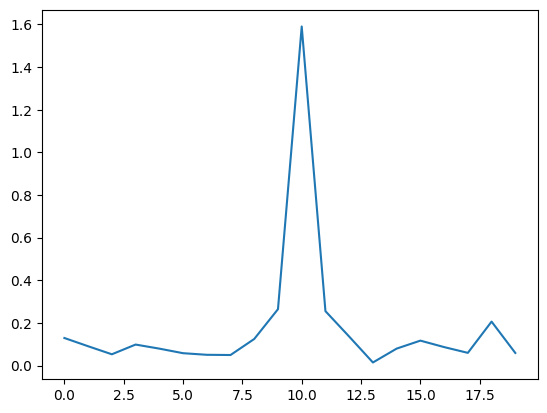

In [15]:
plt.plot(np.fft.fftshift(np.abs(cxcorr[0,:]))[stamp])

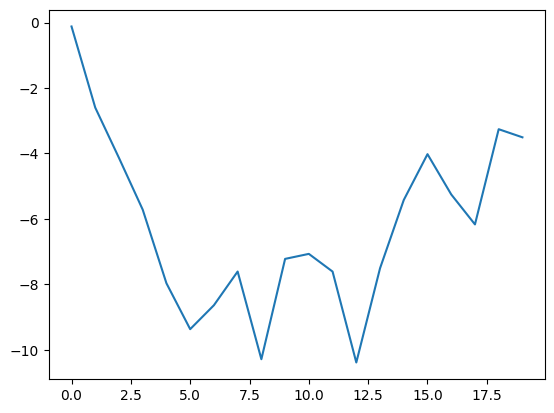

In [48]:
plt.plot(np.unwrap(np.angle(np.fft.fftshift(cxcorr[0,:])[stamp])))

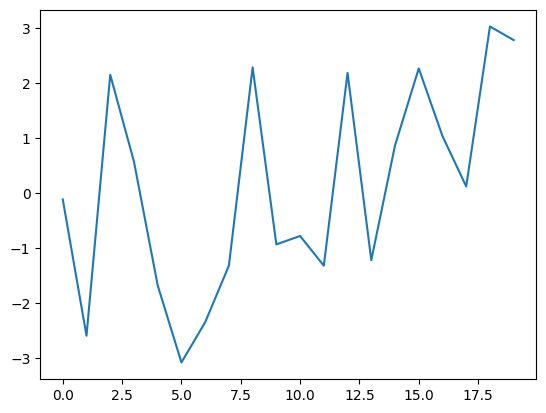

In [ ]:
plt.plot(np.angle(np.fft.fftshift(cxcorr[0,:])[stamp]))

In [50]:
# deltanu=250e6/4096
# np.arange(-10,10)*4096/250e6
tau0=0
def model_xcorr(params,y):
    a,tau0=params
    # z=y-a*np.sinc(1*np.arange(-10,10) - tau0/4096) * np.exp(2j*np.pi*1834*(np.arange(-10,10)-tau0/4096))
    z=y-a*np.sinc(1*np.arange(-10,10) - tau0/(2*np.pi*1834)) * np.exp(-1j*tau0)
    return np.hstack([z.real,z.imag])
# plt.plot(np.max(y))

In [168]:
def fit_drift(params,xc):
    # print("y1",y1)
    # print("y2",y2)
    delta,ar,ai=params
    z=ar+1j*ai-xc*np.exp(2j*np.pi*1834*np.arange(0,len(xc))*delta/4096) #assume there's no extra phase, perfect beamforming
    return np.hstack([z.real,z.imag])

def fit_drift2(params,y1,y2):
    delta,ar,ai=params
    z=y1-(ar+1j*ai)*y2*np.exp(2j*np.pi*1834*np.arange(0,len(y1))*delta/4096) #assume there's no extra phase, perfect beamforming
    return np.hstack([z.real,z.imag])
# plt.plot(np.max(y))

In [182]:
y1=spec1[10000:20000,4]
y2=spec2[10000:20000,4]
xc_small = y1*np.conj(y2)
print(np.mean(xc_small))
xc_small = xc_small * np.exp(-1j*np.angle(xc_small)[0])
xc_spec = np.fft.fft(xc_small)
print(np.angle(xc_small))
np.mean(xc_small)
#whether or not FFT will be useful depends on whether we can resolve the slow sine wave across the chunk being FFT'ed.

(-0.772220161474336-1.3166061878792539j)
[1.29462719e-17 1.86721715e+00 2.76743464e+00 ... 2.45907721e+00
 1.09970824e+00 8.46025206e-01]


np.complex128(1.3436208800406668-0.7241952516194333j)

In [183]:
sol=least_squares(fit_drift2,[0,-1,1],args=(y1,y2),ftol=1e-12,jac='3-point')
print(sol)

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 2.927e+00  1.704e-01 ...  2.197e+00  8.306e-01]
           x: [-4.710e-05  1.721e-02 -1.630e-01]
        cost: 47976.104374506984
         jac: [[ 0.000e+00  1.346e+00  1.476e+00]
               [-8.267e-01 -2.059e+00  2.425e+00]
               ...
               [-9.394e+03 -2.062e+00  2.903e-02]
               [-1.604e+04 -3.702e+00  1.760e+00]]
        grad: [-5.384e+02 -6.855e-02 -6.787e-03]
  optimality: 538.4230877941009
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 14
        njev: 7


In [180]:
gain=(sol['x'][1] + 1j*sol['x'][2])
drift=sol['x'][0]
y2new=gain*y2*np.exp(2j*np.pi*1834*np.arange(0,len(y1))*drift/4096)
np.mean(y1*np.conj(y2new))

np.complex128(0.29105707444295853+5.728637574975438e-10j)

In [184]:
gain=(sol['x'][1] + 1j*sol['x'][2])
drift=sol['x'][0]
y2new=gain*y2*np.exp(2j*np.pi*1834*np.arange(0,len(y1))*drift/4096)
np.mean(y1*np.conj(y2new))

np.complex128(0.2685225597554292+1.1288029915274223e-06j)

In [145]:
y1=spec1[:10000,4]
y2=spec2[:10000,4]
np.mean(xc_small*np.exp(2j*np.pi*1834*np.arange(0,len(y2))*(-5e-5)/4096))

np.complex128(-1.2170435174163978-0.24787015939654922j)

In [164]:
y1new=y1*np.exp(-1j*np.angle(xc_small)[0])
y2new=0.1706*y2*np.exp(2j*np.pi*1834*np.arange(0,len(y1))*(-5.25e-5)/4096)
xcnew=y1new*np.conj(y2new)

In [165]:
np.mean(xcnew)

np.complex128(0.289757910717659-0.009429675114092635j)

In [167]:
np.mean(xc_small*np.exp(2j*np.pi*1834*np.arange(0,len(y1))*(5.25e-5)/4096))

np.complex128(0.1715104729854334-1.6906857595950184j)

49999


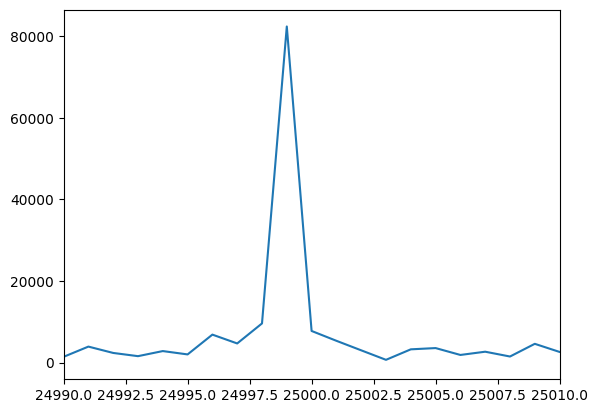

In [131]:
plt.plot(np.fft.fftshift(np.abs(xc_spec)))
plt.xlim(25000-10,25000+10)
print(np.argmax(np.abs(xc_spec)))

In [105]:
np.abs(xc_avg[0,4])

np.float64(1.5905642403477611)

In [32]:
y=np.fft.fftshift(cxcorr[0,:])[stamp].copy()

In [54]:
least_squares(model_xcorr,[1,12.],bounds=([0,0],[2,4096]),args=(y,),xtol=1e-12,jac='3-point')

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 1.280e-01 -7.726e-02 ...  2.390e-02  2.116e-02]
           x: [ 1.591e+00  1.335e+01]
        cost: 0.14890938850988636
         jac: [[-8.195e-05  1.205e-04]
               [ 9.105e-05 -1.339e-04]
               ...
               [-1.024e-04 -1.752e-04]
               [ 9.101e-05  1.557e-04]]
        grad: [-4.322e-09  3.222e-11]
  optimality: 1.7698646869647308e-09
 active_mask: [0 0]
        nfev: 8
        njev: 8

In [57]:
xc=spec1*np.conj(spec2)
avglen=10000
xc_avg=average_rows(xc,nblock=avglen)

In [68]:
cxcorr = get_coarse_xcorr(spec1[:10000,4:6], spec2[:10000,4:6])
y=np.fft.fftshift(cxcorr[0,:])[stamp].copy()

Shape of passed channelized timestream = (10000, 2)
[10000.  9999.  9998. ...  9997.  9998.  9999.]
processing chan 0
processing chan 1
(2, 20000)


/tmp/ipykernel_1049567/393562261.py:35: RuntimeWarning: divide by zero encountered in divide
  xcorr[i, :]=xcorr[i, :]/n_avg


In [70]:
np.angle(xc_avg[0,4]),np.angle(y[dN])

(np.float64(-0.7849599189083842), np.float64(-0.784959918908385))

In [74]:
cxcorr2 = get_coarse_xcorr(spec1[10000:2*10000,4:6], spec2[10000:2*10000,4:6]*np.exp(1j*np.angle(xc_avg[0,4:6]))*np.exp(-1j*np.angle(xc_avg[1,4:6])))
y2=np.fft.fftshift(cxcorr2[0,:])[stamp].copy()

Shape of passed channelized timestream = (10000, 2)
[10000.  9999.  9998. ...  9997.  9998.  9999.]
processing chan 0
processing chan 1
(2, 20000)


/tmp/ipykernel_1049567/393562261.py:35: RuntimeWarning: divide by zero encountered in divide
  xcorr[i, :]=xcorr[i, :]/n_avg


Shape of passed channelized timestream = (10000, 2)
[10000.  9999.  9998. ...  9997.  9998.  9999.]
processing chan 0
processing chan 1
(2, 20000)
Shape of passed channelized timestream = (10000, 2)
[10000.  9999.  9998. ...  9997.  9998.  9999.]
processing chan 0
processing chan 1
(2, 20000)
Shape of passed channelized timestream = (10000, 2)
[10000.  9999.  9998. ...  9997.  9998.  9999.]
processing chan 0
processing chan 1
(2, 20000)
Shape of passed channelized timestream = (10000, 2)
[10000.  9999.  9998. ...  9997.  9998.  9999.]
processing chan 0
processing chan 1
(2, 20000)


/tmp/ipykernel_1049567/393562261.py:35: RuntimeWarning: divide by zero encountered in divide
  xcorr[i, :]=xcorr[i, :]/n_avg
/tmp/ipykernel_1049567/393562261.py:35: RuntimeWarning: invalid value encountered in divide
  xcorr[i, :]=xcorr[i, :]/n_avg


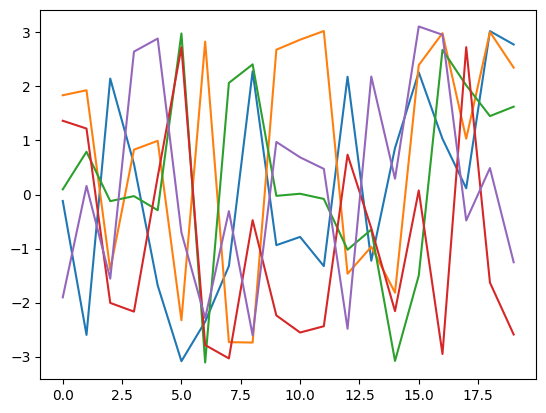

In [76]:
plt.plot(np.angle(np.fft.fftshift(cxcorr[0,:])[stamp]))
for i in range(1,xc_avg.shape[0]):
    cxcorr2 = get_coarse_xcorr(spec1[i*10000:(i+1)*10000,4:6], spec2[i*10000:(i+1)*10000,4:6]*np.exp(1j*np.angle(xc_avg[0,4:6]))*np.exp(-1j*np.angle(xc_avg[i,4:6])))
    y2=np.fft.fftshift(cxcorr2[0,:])[stamp].copy()
    plt.plot(np.angle(np.fft.fftshift(cxcorr2[0,:])[stamp]))

In [ ]:
osamp=40
xcorr_arr = np.zeros((len(k),(2*dN-1)*4096*osamp),dtype='complex128') #this is just the array to store the values
sample_no=np.arange(0,(2*dN-1)*4096*osamp)#-delay*osamp # we want values at these locations
coarse_sample_no=np.arange(0,2*dN)*4096*osamp #we have values at these locations
